# **Model and Evaluation of Softmax**

## Objectives

* Answer Business Requirement 2: Develop an ML model that classifies leaf images into these two categories; healthy or containing powdery mildew.

## Inputs

* inputs/cherryleaves_dataset/cherry-leaves/test
* inputs/cherryleaves_dataset/cherry-leaves/train
* inputs/cherryleaves_dataset/cherry-leaves/validation
* image shape embeddings.

```plaintext
├── inputs
│ └── cherryleaves_dataset
│ └── cherry-leaves
│   ├── test
│   │ ├── healthy
│   │ └── powdery_mildew
│   ├── train
│   │ ├── healthy
│   │ └── powdery_mildew
│   └── validation
│   │ ├── healthy
│   │ └── powdery_mildew
└── ...
``` 

## Outputs

* Image distribution plot in train, validation, and test set
* Image augementation
* Class indices to change prediction inference in labels
* Creation of ML model
* Train ML model
* Save ML model
* Create Learning Curve Plot for model performance
* Model Evaluation on pickle file
* Prediction on the random image file

---

# Import packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import tensorflow as tf
from matplotlib.image import imread

---

# Set working directory

In [2]:
cwd = os.getcwd()

In [3]:
os.chdir('/workspace/mildew-detector')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detector'

---

## Set input directories
Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set label names

In [7]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

## Images distribution 

### Count number of images per set and label

In [9]:
import plotly.express as px

df_freq = pd.DataFrame([])
for folder in ['train', 'test', 'validation']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Count': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images




### Label Distribution - Bar Chart

In [13]:
fig = px.bar(df_freq, 
            x="Set", 
            y="Count", 
            color='Label', 
            title="Cherry Leaves Dataset", 
            text="Count")
fig.update_layout(
    autosize=False,
    width=800, 
    height=500, 
    )
fig.show()
fig.write_image(f'{file_path}/number_leaves_sets.png')

ValueError: 
The orca executable is required to export figures as static images,
but it could not be found on the system path.

Searched for executable 'orca' on the following path:
    /home/gitpod/.pyenv/versions/3.8.18/bin
    /ide/bin/remote-cli
    /ide/bin/remote-cli
    /workspace/.pip-modules/bin
    /home/gitpod/.pyenv/bin
    /home/gitpod/.pyenv/shims
    /home/gitpod/.local/bin
    /usr/games
    /usr/local/sbin
    /usr/local/bin
    /usr/sbin
    /usr/bin
    /sbin
    /bin

If you haven't installed orca yet, you can do so using conda as follows:

    $ conda install -c plotly plotly-orca

Alternatively, see other installation methods in the orca project README at
https://github.com/plotly/orca

After installation is complete, no further configuration should be needed.

If you have installed orca, then for some reason plotly.py was unable to
locate it. In this case, set the `plotly.io.orca.config.executable`
property to the full path of your orca executable. For example:

    >>> plotly.io.orca.config.executable = '/path/to/orca'

After updating this executable property, try the export operation again.
If it is successful then you may want to save this configuration so that it
will be applied automatically in future sessions. You can do this as follows:

    >>> plotly.io.orca.config.save()

If you're still having trouble, feel free to ask for help on the forums at
https://community.plot.ly/c/api/python


### Set Distribution - Pie Chart

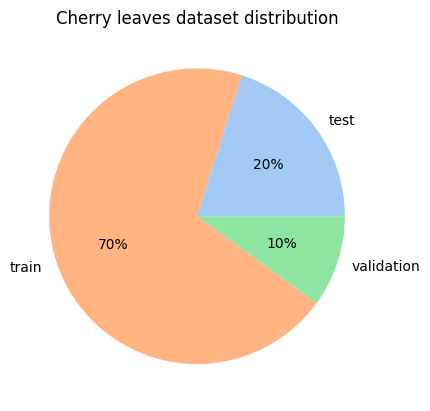

In [14]:
folders = os.listdir(my_data_dir)
data=[]
for folder in folders:
    for label in labels:
        n=int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))
        n+=n
    data.append(n)


colors = sns.color_palette('pastel')[0:5]
plt.pie(data, labels = folders, colors = colors, autopct='%.0f%%')
plt.title('Cherry leaves dataset distribution')
plt.savefig(f'{file_path}/sets_distribution_pie.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

## Image data augmentation

### Import ImageDataGenerator

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [16]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Set Batch Size

In [17]:
batch_size = 16

### Augment training image set

In [18]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='categorical',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training image set

(16, 256, 256, 3)


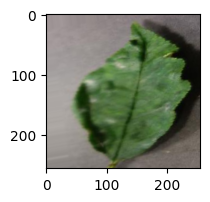

(16, 256, 256, 3)


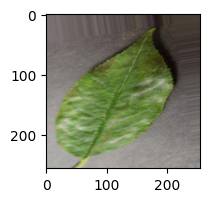

(16, 256, 256, 3)


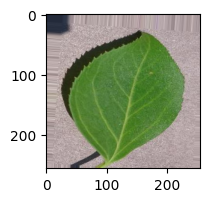

In [19]:
%matplotlib inline
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = train_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Augment validation image set

In [20]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='categorical',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented validation image set

(16, 256, 256, 3)


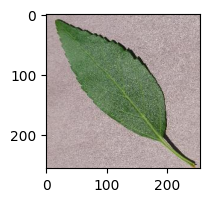

(16, 256, 256, 3)


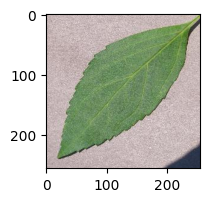

(16, 256, 256, 3)


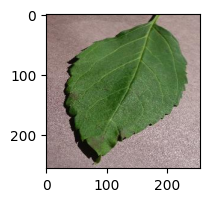

In [21]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = validation_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Augment test image set

In [22]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='categorical',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented test image set

(16, 256, 256, 3)


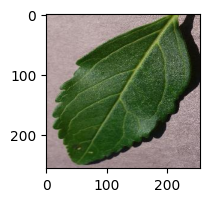

(16, 256, 256, 3)


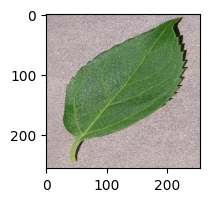

(16, 256, 256, 3)


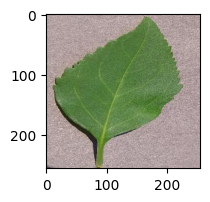

In [23]:
for _ in range(3):
    plt.figure(figsize=(2, 2))
    img, label = test_set.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [24]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

## Model Creation

### Import packages

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad

### Model

In [26]:
def create_tf_model():
    model = Sequential()

    ### input layer
    model.add(Conv2D(32, (3, 3), input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ### convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))      
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ### fully connected layer
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(.2))

    ### output
    model.add(Dense(2, activation='softmax')) 

    model.compile(loss='categorical_crossentropy', 
                  optimizer='adagrad',
                  metrics=['accuracy'])

    return model

### Model Summary

In [27]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

2024-08-31 08:47:19.925277: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Callbacks

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_accuracy',mode='max',verbose=1, patience=2)
m_checkpoint = ModelCheckpoint(filepath='outputs/v1/powdery_mildew_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)

### Fit model for training

In [30]:
model = create_tf_model()
model.fit(train_set,
          batch_size=batch_size,
          epochs=32,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop, m_checkpoint],
          verbose=1
          )

Epoch 1/32
184/184 [==============================] - 201s 1s/step - loss: 0.6087 - accuracy: 0.6926 - val_loss: 0.4418 - val_accuracy: 0.8071
Epoch 2/32
184/184 [==============================] - 203s 1s/step - loss: 0.3849 - accuracy: 0.8346 - val_loss: 0.2636 - val_accuracy: 0.8857
Epoch 3/32
184/184 [==============================] - 202s 1s/step - loss: 0.3119 - accuracy: 0.8692 - val_loss: 0.2545 - val_accuracy: 0.8833
Epoch 4/32
184/184 [==============================] - 202s 1s/step - loss: 0.2657 - accuracy: 0.8893 - val_loss: 0.2181 - val_accuracy: 0.8929
Epoch 5/32
184/184 [==============================] - 204s 1s/step - loss: 0.2224 - accuracy: 0.9107 - val_loss: 0.1438 - val_accuracy: 0.9619
Epoch 6/32
184/184 [==============================] - 202s 1s/step - loss: 0.1822 - accuracy: 0.9327 - val_loss: 0.1253 - val_accuracy: 0.9619
Epoch 7/32
184/184 [==============================] - 202s 1s/step - loss: 0.1452 - accuracy: 0.9555 - val_loss: 0.0906 - val_accuracy: 0.9833

### Load saved best model

In [31]:
from keras.models import load_model

load_model('outputs/v1/powdery_mildew_model.h5')

---

## Model Performance

### Model learining curve - A

<Figure size 500x400 with 0 Axes>

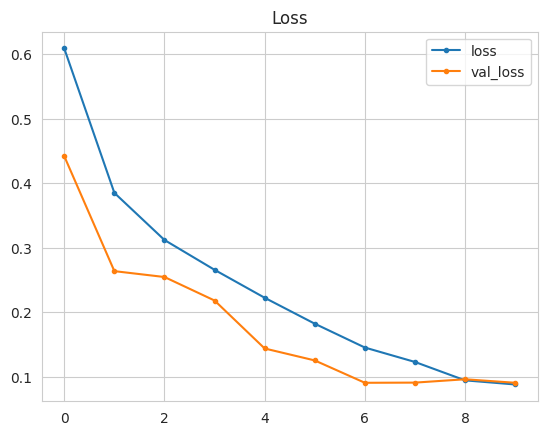

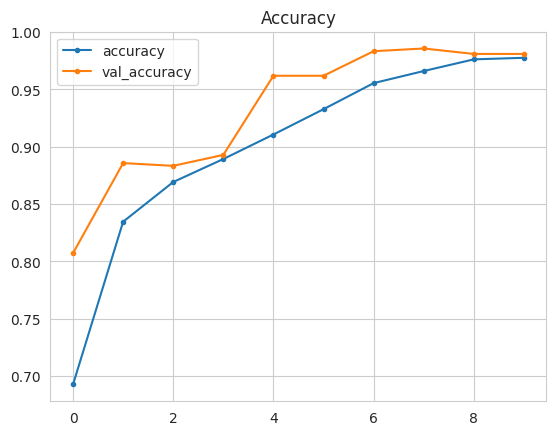

In [32]:
losses = pd.DataFrame(model.history.history)
plt.figure(figsize=(5, 4))
sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)

### Model learining curve - B

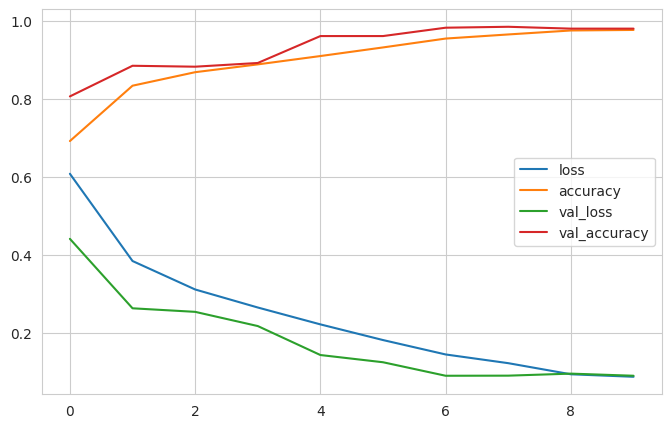

In [33]:
pd.DataFrame(model.history.history).plot(figsize=(8,5))
plt.savefig(f'{file_path}/model_loss_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Model learining curve - C

In [38]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter( y=model.history.history['val_loss'], name="val_loss"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter( y=model.history.history['loss'], name="loss"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter( y=model.history.history['val_accuracy'], name="val accuracy"),
    secondary_y=True,
)
fig.add_trace(
    go.Scatter( y=model.history.history['accuracy'], name="accuracy"),
    secondary_y=True,
)

fig.update_layout(
    title_text="Loss/Accuracy of LSTM Model (softmax/rgb)"
)

fig.update_xaxes(title_text="Epoch")

fig.update_yaxes(title_text="<b>primary</b> Loss", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> Accuracy", secondary_y=True)

fig.update_layout(
    autosize=False,
    width=800, 
    height=500, 
    )

fig.show()
fig.write_image(f'{file_path}/model_history.png')

ValueError: 
The orca executable is required to export figures as static images,
but it could not be found on the system path.

Searched for executable 'orca' on the following path:
    /home/gitpod/.pyenv/versions/3.8.18/bin
    /ide/bin/remote-cli
    /ide/bin/remote-cli
    /workspace/.pip-modules/bin
    /home/gitpod/.pyenv/bin
    /home/gitpod/.pyenv/shims
    /home/gitpod/.local/bin
    /usr/games
    /usr/local/sbin
    /usr/local/bin
    /usr/sbin
    /usr/bin
    /sbin
    /bin

If you haven't installed orca yet, you can do so using conda as follows:

    $ conda install -c plotly plotly-orca

Alternatively, see other installation methods in the orca project README at
https://github.com/plotly/orca

After installation is complete, no further configuration should be needed.

If you have installed orca, then for some reason plotly.py was unable to
locate it. In this case, set the `plotly.io.orca.config.executable`
property to the full path of your orca executable. For example:

    >>> plotly.io.orca.config.executable = '/path/to/orca'

After updating this executable property, try the export operation again.
If it is successful then you may want to save this configuration so that it
will be applied automatically in future sessions. You can do this as follows:

    >>> plotly.io.orca.config.save()

If you're still having trouble, feel free to ask for help on the forums at
https://community.plot.ly/c/api/python


---

## Model Evaluation

### Import packages

In [39]:
import sklearn
import sklearn.metrics as metrics

### Load saved model

In [40]:
from keras.models import load_model
model = load_model('outputs/v1/powdery_mildew_model.h5')

### Accuracy

In [41]:
evaluation = model.evaluate(test_set, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: ",evaluation[0])

53/53 [==============================] - 14s 262ms/step - loss: 0.0719 - accuracy: 0.9882
Model accuracy: 98.82%
Model Loss:  0.07187163829803467


### Set accuracy variables

In [42]:
validation_set.reset()

x_true, y_true = next(test_set)
preds = np.argmax(model.predict(test_set), axis=1)
y_pred = np.rint(preds)
y_true = test_set.labels

### ROC Curve

Area Under ROC-Curve:  0.9881516587677726


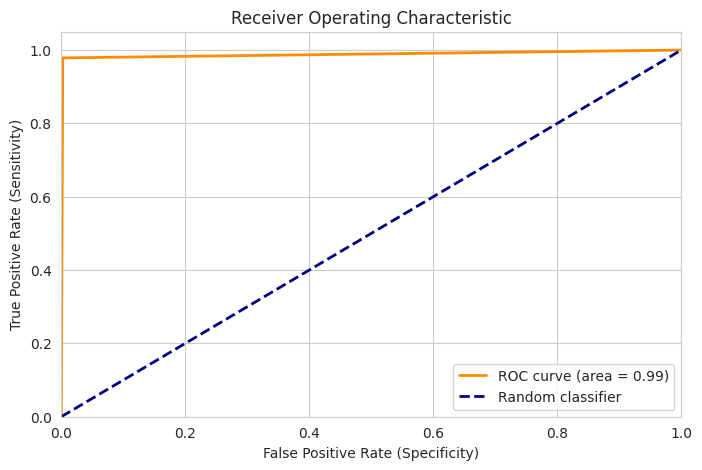

In [43]:
from sklearn.metrics import roc_curve, auc, accuracy_score, roc_auc_score

sns.set_style("whitegrid")
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, label="Random classifier", linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig(f'{file_path}/roccurve.png',
            bbox_inches='tight', dpi=150)
print('Area Under ROC-Curve: ', roc_auc_score(y_true, y_pred))
plt.show()

### Classification Report

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

In [45]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [46]:
print('Classification Report:\n----------------------\n')
print(classification_report(y_true, y_pred, target_names=labels))

Classification Report:
----------------------

                precision    recall  f1-score   support

       healthy       0.98      1.00      0.99       422
powdery_mildew       1.00      0.98      0.99       422

      accuracy                           0.99       844
     macro avg       0.99      0.99      0.99       844
  weighted avg       0.99      0.99      0.99       844



### Confusion Matrix

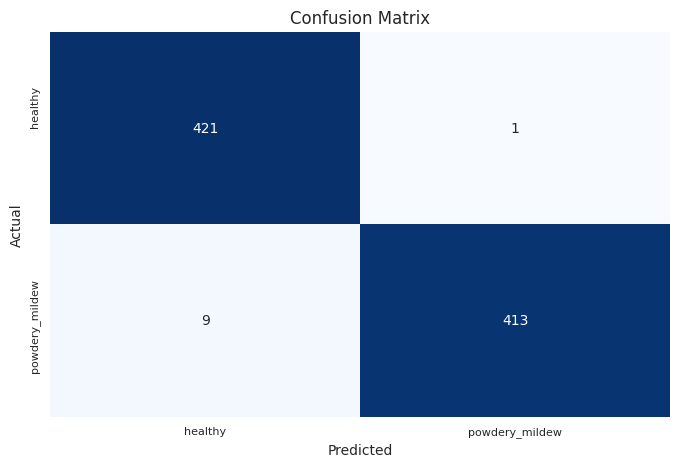

In [47]:
cm =confusion_matrix(y_true,y_pred)

classes=list(test_set.class_indices.keys()) 
length=len(classes)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
plt.xticks(np.arange(length)+.5, classes, rotation= 0, fontsize=8)
plt.yticks(np.arange(length)+.3, classes, rotation=90, fontsize=8)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig(f'{file_path}/confusion_matrix.png',
            bbox_inches='tight', dpi=150)
plt.show()

### Save evaluation pickle

In [48]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

---

## Predict on new data

### Load random image as PIL

Image shape: (256, 256), Image mode: RGB


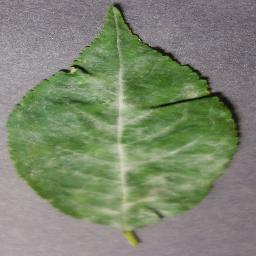

In [49]:
from tensorflow.keras.preprocessing import image

pointer = 32
label = labels[1] # select 0 for 'healthy' or 1 for 'powdery_mildew'

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

### Convert image to array and prepare for prediction

In [50]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


### Predict class probabilities

In [51]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba < 0.5]

if pred_class == target_map[1]:
    pred_proba = 1 - pred_proba

print(f"{pred_class} {round(pred_proba*100, 2)}%")

powdery_mildew 98.81%
